## ПРОМЫШЛЕННОСТЬ: ПРЕДСКАЗАНИЕ ТЕМПЕРАТУРЫ СПЛАВА СТАЛИ

### ОПИСАНИЕ ПРОЕКТА

Заказчик проекта - металлургический комбинат «Стальная птица».\
Чтобы оптимизировать производственные расходы, заказчику нужно уменьшить потребление электроэнергии на этапе обработки стали.\
Для этого комбинату нужно контролировать температуру сплава.\
Данные, предоставленные комбинатом, состоят из нескольких файлов, полученных из разных источников:

### ЗАДАЧА ПРОЕКТА

Задача проекта — построить модель, которая будет предсказывать температуру сплава стали с целевым химическим составом.

### ПЛАН ПРОЕКТА

1. [Загрузка и изучение данных](#1)
2. [Исследовательский анализ и предобработка данных](#2)
3. [Объединение данных](#3)
4. [Исследовательский анализ и предобработка датафрейма gen_df](#4)
5. [Подготовка данных](#5)
6. [Обучение моделей](#6)
7. [Проверка лучшей модели](#7)
8. [Общий вывод и рекомендации заказчику](#8)

<a id="1"></a>
# Загрузка и изучение данных

## Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install shap -q

In [3]:
!pip install phik -q

In [4]:
!pip install -Uq scikit-learn

Импортируем необходимые библиотеки

In [5]:
# импорт pandas и необходимых библиотек
import jupyter_black
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import phik
import seaborn as sns
import shap
import warnings

from joblib import dump, load
from lightgbm import LGBMRegressor
from matplotlib.colors import LinearSegmentedColormap
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 160625

Откроем файлы, прочтем и запишем в переменные.

In [6]:
# объявление переменных
arc_file = "....csv"
bulk_file = "....csv"
bulk_time_file = "....csv"
gas_file = "....csv"
temp_file = "....csv"
wire_file = "....csv"
wire_time_file = "....csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file, delimiter, decimal, parse_dates):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(
                path1,
                sep=delimiter,
                decimal=decimal,
                parse_dates=parse_dates,
            )
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(
                path2,
                sep=delimiter,
                decimal=decimal,
                parse_dates=parse_dates,
            )
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную arc_df
arc_df = get_read_file(
    general_path,
    user_path,
    arc_file,
    ",",
    ".",
    ["Начало нагрева дугой", "Конец нагрева дугой"],
)
arc_df.name = "arc_df"
# чтение csv-файла в датафрейм с сохранением в переменную bulk_df
bulk_df = get_read_file(
    general_path,
    user_path,
    bulk_file,
    ",",
    ".",
    [],
)
bulk_df.name = "bulk_df"
# чтение csv-файла в датафрейм с сохранением в переменную bulk_time_df
bulk_time_df = get_read_file(
    general_path,
    user_path,
    bulk_time_file,
    ",",
    ".",
    [
        "Bulk 1",
        "Bulk 2",
        "Bulk 3",
        "Bulk 4",
        "Bulk 5",
        "Bulk 6",
        "Bulk 7",
        "Bulk 8",
        "Bulk 9",
        "Bulk 10",
        "Bulk 11",
        "Bulk 12",
        "Bulk 13",
        "Bulk 14",
        "Bulk 15",
    ],
)
bulk_time_df.name = "bulk_time_df"
# чтение csv-файла в датафрейм с сохранением в переменную gas_df
gas_df = get_read_file(
    general_path,
    user_path,
    gas_file,
    ",",
    ".",
    [],
)
gas_df.name = "gas_df"
# чтение csv-файла в датафрейм с сохранением в переменную temp_df
temp_df = get_read_file(
    general_path,
    user_path,
    temp_file,
    ",",
    ".",
    ["Время замера"],
)
temp_df.name = "temp_df"
# чтение csv-файла в датафрейм с сохранением в переменную wire_df
wire_df = get_read_file(general_path, user_path, wire_file, ",", ".", [])
wire_df.name = "wire_df"
# чтение csv-файла в датафрейм с сохранением в переменную wire_time_df
wire_time_df = get_read_file(
    general_path,
    user_path,
    wire_time_file,
    ",",
    ".",
    [
        "Wire 1",
        "Wire 2",
        "Wire 3",
        "Wire 4",
        "Wire 5",
        "Wire 6",
        "Wire 7",
        "Wire 8",
        "Wire 9",
    ],
)
wire_time_df.name = "wire_time_df"

## Изучение данных

Изучим общую информацию о полученных датафреймах

In [7]:
# объявление списка датафреймов
df_lst = [arc_df, bulk_df, bulk_time_df, gas_df, temp_df, wire_df, wire_time_df]


# функции для вывода информации о датафреймах
def get_method(method):
    return [getattr(df, method) for df in df_lst]


def get_info(df_lst, get_method, flag=True):
    i = 0
    for df in df_lst:
        print(f"Датафрейм - {df.name}")
        print("---------")
        if flag:
            display(get_method[i]())
        else:
            get_method[i]()
        print("")
        i += 1


# вывод первых 5-ти строчек датафреймов
get_info(df_lst, get_method("head"))

Датафрейм - arc_df
---------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Датафрейм - bulk_df
---------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Датафрейм - bulk_time_df
---------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



Датафрейм - gas_df
---------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Датафрейм - temp_df
---------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Датафрейм - wire_df
---------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Датафрейм - wire_time_df
---------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [8]:
# вывод основной информации о датафреймах
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - arc_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Датафрейм - bulk_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 n

Обратим внимание на наименования столбцов в датафреймах

In [9]:
# вывод наименований столбцов в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(*df.columns.tolist(), sep="\n")


Датафрейм - arc_df
---------
key
Начало нагрева дугой
Конец нагрева дугой
Активная мощность
Реактивная мощность

Датафрейм - bulk_df
---------
key
Bulk 1
Bulk 2
Bulk 3
Bulk 4
Bulk 5
Bulk 6
Bulk 7
Bulk 8
Bulk 9
Bulk 10
Bulk 11
Bulk 12
Bulk 13
Bulk 14
Bulk 15

Датафрейм - bulk_time_df
---------
key
Bulk 1
Bulk 2
Bulk 3
Bulk 4
Bulk 5
Bulk 6
Bulk 7
Bulk 8
Bulk 9
Bulk 10
Bulk 11
Bulk 12
Bulk 13
Bulk 14
Bulk 15

Датафрейм - gas_df
---------
key
Газ 1

Датафрейм - temp_df
---------
key
Время замера
Температура

Датафрейм - wire_df
---------
key
Wire 1
Wire 2
Wire 3
Wire 4
Wire 5
Wire 6
Wire 7
Wire 8
Wire 9

Датафрейм - wire_time_df
---------
key
Wire 1
Wire 2
Wire 3
Wire 4
Wire 5
Wire 6
Wire 7
Wire 8
Wire 9


Переименуем столбцы:
   - применим английские названия столбцов
   - приведём наименования столбцов к нижнему регистру
   - слова соединим нижним подчёркиванием

In [10]:
# переименование русских названий столбцов
arc_df.rename(
    columns={
        "Начало нагрева дугой": "begin_heat",
        "Конец нагрева дугой": "end_heat",
        "Активная мощность": "active_power",
        "Реактивная мощность": "reactive_power",
    },
    inplace=True,
)
gas_df.rename(columns={"Газ 1": "gas_1"}, inplace=True)
temp_df.rename(columns={"Время замера": "time", "Температура": "temp"}, inplace=True)

In [11]:
# функция для переименования столбцов в датафреймах
def rename_columns(df):
    lst_columns = df.columns.to_list()
    new_lst_columns = []
    for col in lst_columns:
        col = col.lower()
        col = col.replace(" ", "_")
        new_lst_columns.append(col)
    df.columns = new_lst_columns


# переименование столбцов
for df in df_lst:
    rename_columns(df)

In [12]:
# проверка переименования
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - arc_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   begin_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Датафрейм - bulk_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-nul

***

***ВЫВОД:***

1. Данные загружены в датафреймы.
2. Наименования столбцов во всех датафреймах были приведены к единому виду.

<a id="2"></a>
# Исследовательский анализ и предобработка данных

## Предобработка данных

### Предобработка пропусков - удаление

Проверим данные на пропущенные значения

In [13]:
# вывод количества пропущенных значений
for df in df_lst:
    print(df.name, end=" - ")
    print(df.isna().sum().sum())

arc_df - 0
bulk_df - 35776
bulk_time_df - 35776
gas_df - 0
temp_df - 3427
wire_df - 23385
wire_time_df - 23385


Выведем пропуски по датафреймам

In [14]:
# вывод пропусков по столбцам
for df in df_lst:
    if df.isna().sum().sum() != 0:
        print("")
        print(f"Датафрейм - {df.name}")
        display(df.isna().sum().sort_values(ascending=False))
        print("---------")


Датафрейм - bulk_df


bulk_8     3128
bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64

---------

Датафрейм - bulk_time_df


bulk_8     3128
bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64

---------

Датафрейм - temp_df


temp    3427
key        0
time       0
dtype: int64

---------

Датафрейм - wire_df


wire_5    3080
wire_7    3070
wire_4    3067
wire_8    3062
wire_9    3052
wire_3    3018
wire_6    3008
wire_2    2002
wire_1      26
key          0
dtype: int64

---------

Датафрейм - wire_time_df


wire_5    3080
wire_7    3070
wire_4    3067
wire_8    3062
wire_9    3052
wire_3    3018
wire_6    3008
wire_2    2002
wire_1      26
key          0
dtype: int64

---------


In [15]:
# вывод доли пропущенных значений для каждого столбца
def get_percent_passes(df_lst):
    for df in df_lst:
        if df.isna().sum().sum() != 0:
            print("")
            print(f"Датафрейм - {df.name}")
            display(df.isna().mean().sort_values(ascending=False).round(4) * 100)
            print("---------")


get_percent_passes(df_lst)


Датафрейм - bulk_df


bulk_8     99.97
bulk_13    99.42
bulk_9     99.39
bulk_2     99.30
bulk_7     99.20
bulk_5     97.54
bulk_10    94.38
bulk_11    94.34
bulk_1     91.95
bulk_6     81.59
bulk_4     67.59
bulk_3     58.52
bulk_15    28.16
bulk_12    21.70
bulk_14    10.32
key         0.00
dtype: float64

---------

Датафрейм - bulk_time_df


bulk_8     99.97
bulk_13    99.42
bulk_9     99.39
bulk_2     99.30
bulk_7     99.20
bulk_5     97.54
bulk_10    94.38
bulk_11    94.34
bulk_1     91.95
bulk_6     81.59
bulk_4     67.59
bulk_3     58.52
bulk_15    28.16
bulk_12    21.70
bulk_14    10.32
key         0.00
dtype: float64

---------

Датафрейм - temp_df


temp    18.94
key      0.00
time     0.00
dtype: float64

---------

Датафрейм - wire_df


wire_5    99.97
wire_7    99.64
wire_4    99.55
wire_8    99.38
wire_9    99.06
wire_3    97.96
wire_6    97.63
wire_2    64.98
wire_1     0.84
key        0.00
dtype: float64

---------

Датафрейм - wire_time_df


wire_5    99.97
wire_7    99.64
wire_4    99.55
wire_8    99.38
wire_9    99.06
wire_3    97.96
wire_6    97.63
wire_2    64.98
wire_1     0.84
key        0.00
dtype: float64

---------


Так как признаки с большим количеством пропусков не информативны для обучения модели и создают шум,\
удалим столбцы, в которых заполнено менее 10 % значений.\
Перед этим просуммируем значения в признаках, которые будут удалены, с записью суммы в новый признак.

In [16]:
# запись в новый столбец суммы значений
bulk_df["other_bulks"] = (
    bulk_df["bulk_8"].fillna(0)
    + bulk_df["bulk_13"].fillna(0)
    + bulk_df["bulk_9"].fillna(0)
    + bulk_df["bulk_2"].fillna(0)
    + bulk_df["bulk_7"].fillna(0)
    + bulk_df["bulk_5"].fillna(0)
    + bulk_df["bulk_10"].fillna(0)
    + bulk_df["bulk_11"].fillna(0)
    + bulk_df["bulk_1"].fillna(0)
)
wire_df["other_wires"] = (
    wire_df["wire_5"].fillna(0)
    + wire_df["wire_7"].fillna(0)
    + wire_df["wire_4"].fillna(0)
    + wire_df["wire_8"].fillna(0)
    + wire_df["wire_9"].fillna(0)
    + wire_df["wire_3"].fillna(0)
    + wire_df["wire_6"].fillna(0)
)

In [17]:
# объявление списка датафреймов
df_lst_remove = [arc_df, bulk_df, gas_df, temp_df, wire_df]

# удаление столбцов в датафреймах по условию
for df in df_lst_remove:
    if df.isna().sum().sum() != 0:
        lst_columns = df.columns.to_list()
        col_drop_lst = []
        for col in lst_columns:
            if 100 - (df[col].isna().mean() * 100) < 10:
                col_drop_lst.append(col)
        df.drop([*col_drop_lst], axis=1, inplace=True)

Проверим удаление

In [18]:
# вызов функции для проверки удаления столбцов
get_percent_passes(df_lst_remove)


Датафрейм - bulk_df


bulk_6         81.59
bulk_4         67.59
bulk_3         58.52
bulk_15        28.16
bulk_12        21.70
bulk_14        10.32
key             0.00
other_bulks     0.00
dtype: float64

---------

Датафрейм - temp_df


temp    18.94
key      0.00
time     0.00
dtype: float64

---------

Датафрейм - wire_df


wire_2         64.98
wire_1          0.84
key             0.00
other_wires     0.00
dtype: float64

---------


### Предобработка пропусков - заполнение

Пропуски в значениях `'bulk_'` и `'wire_'` в датафреймах:
- **bulk_df**,
- **wire_df**

означают отсутствие данных.\
Поэтому заполним их нулевыми значениями.

In [19]:
# заполнение пропусков нулями
bulk_df.fillna(0, inplace=True)
wire_df.fillna(0, inplace=True)

In [20]:
# вызов функции для проверки заполнения
get_percent_passes(df_lst_remove)


Датафрейм - temp_df


temp    18.94
key      0.00
time     0.00
dtype: float64

---------


### Предобработка датафрейма **temp_df**

Сгруппируем данные датафрейма **temp_df**,\
чтобы найти начальную и конечную температуру каждой партии.\
Для этого вначале найдем начальную и конечную временные точки каждой партии.

In [21]:
# группировка и нахождение минимального и максимального значений
by_min_time = temp_df.groupby("key")["time"].min()
by_max_time = temp_df.groupby("key")["time"].max()

Объединим полученные данные с датафреймом **temp_df** так,\
чтобы сведения о начальной и конечной температуре в каждой партии\
располагались в одну строку.

In [22]:
# для начальной температуры объединение с temp_df
start_temp = pd.merge(by_min_time, temp_df, on=["time"]).drop("time", axis=1)
# переименование столбца
start_temp.rename(columns={"temp": "start_temp"}, inplace=True)

# для конечной температуры объединение с temp_df
finish_temp = pd.merge(by_max_time, temp_df, on=["time"]).drop("time", axis=1)
# переименование столбца
finish_temp.rename(columns={"temp": "finish_temp"}, inplace=True)

Получим датафрейм с данными о начальной и конечной температуре партий.

In [23]:
# объединение по ключу
interval_temp_df = pd.merge(start_temp, finish_temp, on=["key", "key"])

Так как партии с отсутствующей информацией о начальной,\
либо о конечной температуре не информативны для предсказания,\
удалим строки с отсутствующими значениями.

In [24]:
# удаление строк с пропусками
interval_temp_df.dropna(inplace=True)
# проверка удаления
interval_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2477 non-null   int64  
 1   start_temp   2477 non-null   float64
 2   finish_temp  2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB


### Предобработка датафрейма **arc_df**

Перед предобработкой датафрейма выведем описательную статистику для количественных признаков датафрейма

In [25]:
# вывод описательной статистики для количественных признаков датасета
arc_df.drop("key", axis=1).describe().round(3)

,begin_heat,end_heat,active_power,reactive_power
count,14876,14876,14876.000,14876.000
mean,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.663,0.439
min,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223,-715.480
25%,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467,0.337
50%,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.600,0.442
75%,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830,0.608
max,2019-09-06 17:24:54,2019-09-06 17:26:15,1.464,1.270
std,NaN,NaN,0.259,5.873


Очевидно не может быть отрицательных значений реактивной мощности - это аномалия.

Выведем строки с аномальными значениями в признаке `'reactive_power'`

In [26]:
# вывод строк по условию
arc_df.query("reactive_power < 0")

,key,begin_heat,end_heat,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Такая строка одна.\
Удалим её.

In [27]:
# перезапись датафрейма по условию
arc_df = arc_df.query("~(reactive_power < 0)")

Для конечной температуры сплава очевидно может быть важен такой параметр,\
как время нагрева дугой.\
Поэтому найдём время нагрева сначала для каждого цикла нагрева.\
Переведём найденное время в секунды.

In [28]:
# объявление нового столбца с расчётом значений
arc_df["heat_time"] = (arc_df["end_heat"] - arc_df["begin_heat"]).dt.total_seconds()

Перегруппируем датафрейм и агрегируем значения:
- для признака `'heat_time'` найдём общее время нагрева за партию
- для признака `'active_power'` найдём среднюю мощность за партию
- для признака `'reactive_power'` найдём среднюю мощность за партию

Запишем данные в новый датафрейм.

In [29]:
# запись в новый датафрейм с группировкой и агрегацией
key_arc_df = (
    arc_df.pivot_table(
        index="key",
        values=["heat_time", "active_power", "reactive_power"],
        aggfunc={"heat_time": "sum", "active_power": "mean", "reactive_power": "mean"},
    )
    .reset_index()
    .rename(
        columns={
            "heat_time": "total_heat_time",
            "active_power": "mean_active_power",
            "reactive_power": "mean_reactive_power",
        }
    )
)

In [30]:
# проверка записи в датафрейм
key_arc_df.head()

,key,mean_active_power,total_heat_time,mean_reactive_power
0,1,0.607346,1098.0,0.428564
1,2,0.534852,811.0,0.363339
2,3,0.812728,655.0,0.587491
3,4,0.676622,741.0,0.514248
4,5,0.563238,869.0,0.421998


### Предобработка остальных датафреймов

По датафреймам **bulk_df**, **gas_df**, **wire_df** дальнейшей преобработки не требуется.

Датафреймы с временем подачи материалов **bulk_time_df**, **wire_time_df**\
для обучения модели использованы не будут.

***

***ВЫВОД:***

1. В результате проверки на пропущенные значения в датафреймах были выявлены пропуски:
   - **arc_df** - 0
   - **bulk_df** - 35776
   - **bulk_time_df** - 35776
   - **gas_df** - 0
   - **temp_df** - 3427
   - **wire_df** - 23385
   - **wire_time_df** - 23385
2. В датафреймах
   - **bulk_df**
   - **bulk_time_df**
   - **wire_df**
   - **wire_time_df**\
   доля пропусков в признаках достигает почти 100%.
3. Так как признаки с большим количеством пропусков не информативны для обучения модели и создают шум,\
   были удалены столбцы, в которых заполнено менее 10% значений.
4. Перед удалением данные в признаках, которые подлежали удалению,\
   были просуммированны с записью суммы в новый признак:
   - в **bulk_df** в признак `'other_bulks'`
   - в **wire_df** в признак `'other_wires'`
5. Пропуски в значениях `'bulk_'` и `'wire_'` в датафреймах:
   - **bulk_df**,
   - **wire_df**\
   означают отсутствие данных.\
   Поэтому они были заполнены нулевыми значениями.
6. Данные датафрейма **temp_df** были сгруппированы так,\
   чтобы найти начальную и конечную температуру каждой партии.
7. Так как партии с отсутствующей информацией о начальной,\
   либо о конечной температуре не информативны для предсказания,\
   были удалены строки с отсутствующими значениями из **temp_df**.
8. В датафрейме **arc_df** была найдена одна строка с аномальным (отрицательным) значением в признаке `'reactive_power'`\
   Эта строка была удалена.
9. Для конечной температуры сплава очевидно может быть важен такой параметр, как время нагрева дугой.\
   Поэтому было найдено время нагрева сначала для каждого цикла нагрева в датафрейме **arc_df**.\
   Найденное время было переведено в секунды.
10. Данные датафрейма **arc_df** были перегруппированны с агрегацией значений:
   - для признака `'heat_time'` найдено общее время нагрева за партию
   - для признака `'active_power'` найдена средняя мощность за партию
   - для признака `'reactive_power'` найдена средняя мощность за партию\
     Данные записаны в новый датафрейм.
11. Датафреймы с временем подачи материалов **bulk_time_df**, **wire_time_df**\
    для обучения модели использованы не будут.

## Иследовательский анализ данных

Дальнейший анализ будет проведён по обновлённому списку датафреймов:
- **key_arc_df**
- **bulk_df**
- **gas_df**
- **interval_temp_df**
- **wire_df**

### Исследовательский анализ датафрейма **key_arc_df**

Проведем статистический анализ признаков в датафрейме **key_arc_df**

Выведем описательную статистику для количественных признаков датафрейма

In [31]:
# вывод описательной статистики для количественных признаков датасета
key_arc_df.drop("key", axis=1).describe().round(3)

,mean_active_power,total_heat_time,mean_reactive_power
count,3214.000,3214.000,3214.000
mean,0.661,794.545,0.486
std,0.128,332.491,0.098
min,0.268,57.000,0.196
25%,0.573,571.000,0.417
50%,0.653,770.000,0.482
75%,0.739,983.000,0.543
max,1.244,4189.000,0.961


В датафрейме 3214 значений.

По признаку `'mean_active_power'`:
- значения в диапазоне от 0,268 до 1,244.
- среднее (0,661) и медиана (0,653) отличаются незначительно.

По признаку `'total_heat_time'`:
- значения в диапазоне от 57 до 4189.
- разница между средним (794,579) и медианой (770) небольшая.
- хотя стандартное отклонение значительно (332,449).

По признаку `'mean_reactive_power'`:
- значения в диапазоне от 0,098 до 0,961.
- среднее (0,486) и медиана (0,482) отличаются незначительно.        

Для большей наглядности построим диаграммы размаха для количественных признаков датафрейма.

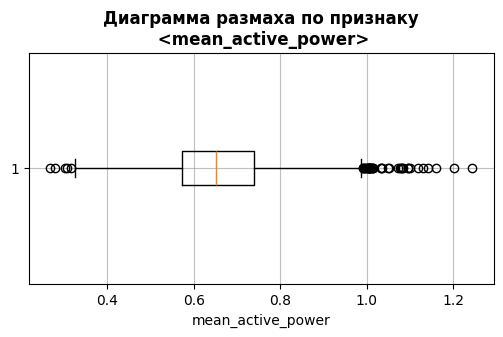

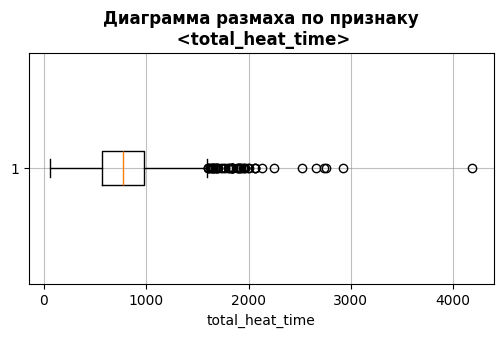

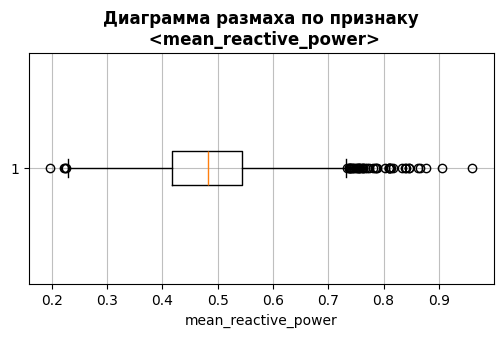

In [32]:
# функция для построения диаграммы размаха
def get_boxplot(df, item):
    plt.rcParams["figure.figsize"] = (
        6,
        3,
    )  # установка параметров графика: размер фигуры

    plt.boxplot(df[item], vert=False)
    plt.title(
        f"Диаграмма размаха по признаку\n <{item}>",
        weight="bold",
    )
    plt.xlabel(f"{item}")
    plt.grid(color="grey", axis="both", alpha=0.5)
    plt.show()


# построение графиков
def set_plot(df, item_lst, plot):
    for item in item_lst:
        plot(df, item)


# построение диаграммы размаха для количественных признаков датасета
set_plot(key_arc_df, key_arc_df.drop("key", axis=1).columns.tolist(), get_boxplot)

На диаграммах размаха видно большое количество выбросов по всем признакам.

### Исследовательский анализ датафрейма **bulk_df**

Проведем статистический анализ признаков в датафрейме **bulk_df**

Выведем описательную статистику для количественных признаков датафрейма

In [33]:
# вывод описательной статистики для количественных признаков датасета
bulk_df.drop("key", axis=1).describe().round(3)

,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulks
count,3129.00,3129.000,3129.000,3129.000,3129.000,3129.000,3129.000
mean,47.24,33.831,21.892,203.948,152.707,115.319,20.566
std,74.24,56.035,55.493,151.420,81.091,84.489,72.177
min,0.00,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.00,0.000,0.000,105.000,104.000,0.000,0.000
50%,0.00,0.000,0.000,206.000,148.000,106.000,0.000
75%,80.00,68.000,0.000,263.000,202.000,204.000,0.000
max,454.00,281.000,503.000,1849.000,636.000,405.000,1187.000


В датафрейме 3129 значений.

По всем признакам минимальные значения равны нулю.

По признакам `'bulk_12'`, `'bulk_14'`, `'bulk_15'`\
среднее и медиана отличаются незначительно.

По остальным признакам медиана равна нулю.

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

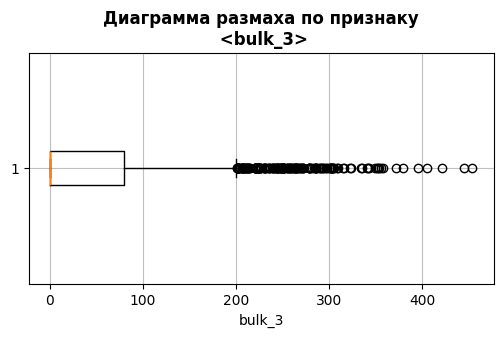

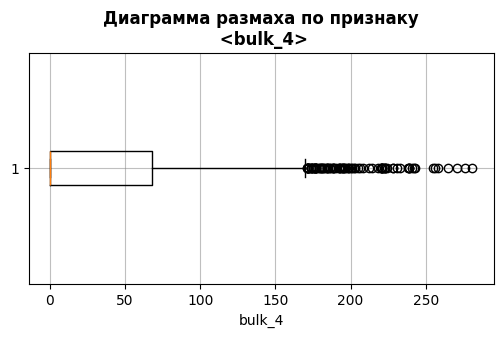

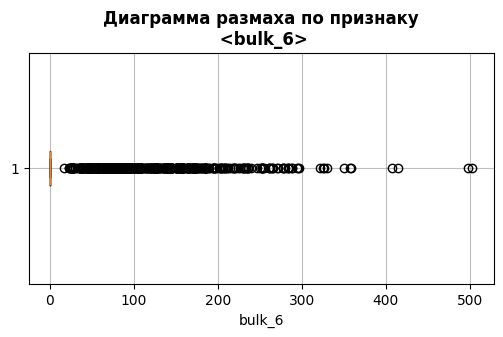

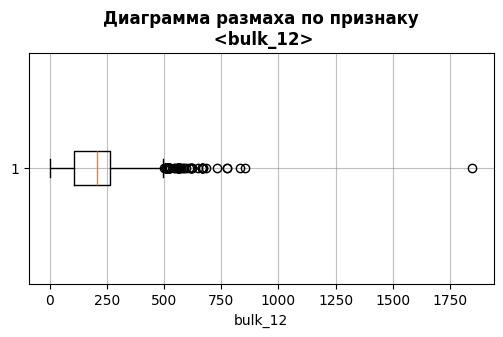

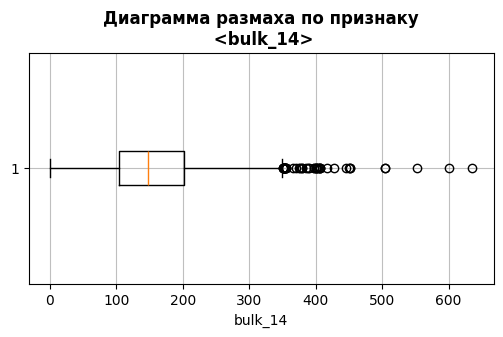

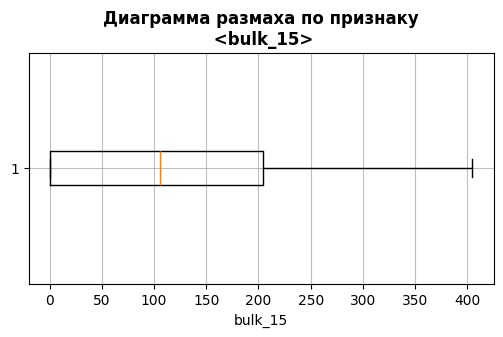

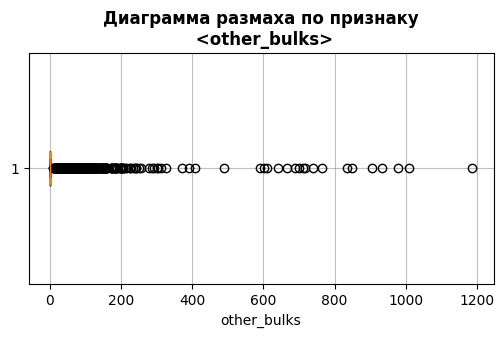

In [34]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(bulk_df, bulk_df.drop("key", axis=1).columns.tolist(), get_boxplot)

На диаграммах размаха по всем признакам, кроме `'bulk_15'`,\
наблюдается большое количество выбросов выше края статистически значимой выборки.

### Исследовательский анализ датафрейма **gas_df**

Проведем статистический анализ признаков в датафрейме **gas_df**

Выведем описательную статистику для количественных признаков датафрейма

In [35]:
# вывод описательной статистики для количественных признаков датасета
gas_df.drop("key", axis=1).describe().round(3)

,gas_1
count,3239.000
mean,11.002
std,6.220
min,0.008
25%,7.043
50%,9.836
75%,13.770
max,77.995


В датафрейме 3239 значений.

Единственный признак `'gas_1'`
- имеет значения в диапазоне от 0,008 до 77,995
- среднее (11,002) и медиана (9,836) имеют ощутимое отличие в значениях.

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

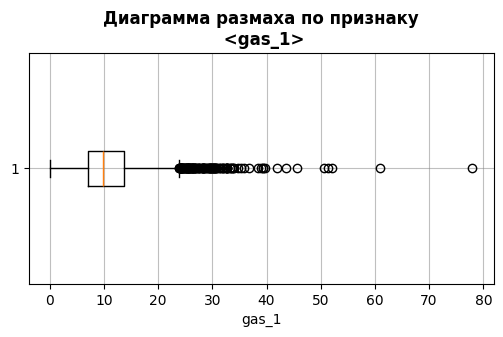

In [36]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(gas_df, gas_df.drop("key", axis=1).columns.tolist(), get_boxplot)

На диаграмме размаха наблюдается большое количество выбросов выше края статистически значимой выборки.

### Исследовательский анализ датафрейма **interval_temp_df**

Проведем статистический анализ признаков в датафрейме **interval_temp_df**

Выведем описательную статистику для количественных признаков датафрейма

In [37]:
# вывод описательной статистики для количественных признаков датасета
interval_temp_df.drop("key", axis=1).describe().round(3)

,start_temp,finish_temp
count,2477.000,2477.000
mean,1588.406,1595.334
std,29.233,16.019
min,1191.000,1541.000
25%,1572.000,1587.000
50%,1588.000,1593.000
75%,1605.000,1599.000
max,1679.000,1700.000


В датафрейме 2477 значений.

По признаку `'start_temp'`:
- значения в диапазоне от 1191 до 1679.
- среднее и медиана отличаются незначительно.

По признаку `'finish_temp'`:
- значения в диапазоне от 1541 до 1700.
- среднее и медиана отличаются незначительно.

По некоторым данным температура расплавленной стали не может быть ниже 1400 градусов Цельсия.
<https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C>\
<https://cnc66.ru/blog/temperatura-plavleniya-stali--na-chto-vliyaet-i-ot-chego-zavisit>

Выведем строки с температурой стали менее 1400 в признаке `'start_temp'`

In [38]:
# вывод строк датафрейма по условию
interval_temp_df.query("start_temp < 1400")

,key,start_temp,finish_temp
855,867,1191.0,1599.0
1201,1214,1208.0,1591.0
1604,1619,1218.0,1590.0
2036,2052,1227.0,1592.0


Таких строк 4.\
Удалим их.

In [39]:
# перезапись датафрейма по условию
interval_temp_df = interval_temp_df.query("start_temp > 1400")

Теперь для большей наглядности построим диаграммы размаха для количественных признаков датасета.

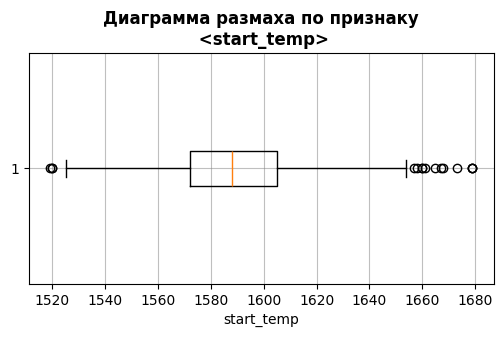

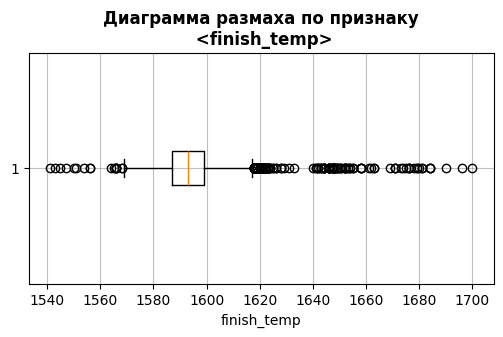

In [40]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(
    interval_temp_df, interval_temp_df.drop("key", axis=1).columns.tolist(), get_boxplot
)

На диаграммах размаха по обоим признакам наблюдаются выбросы\
как выше, так и ниже края статистически значимой выборки.\
По признаку `'finish_temp'` выбросов значительно больше.

### Исследовательский анализ датафрейма **wire_df**

Проведем статистический анализ признаков в датафрейме **wire_df**

Выведем описательную статистику для количественных признаков датафрейма

In [41]:
# вывод описательной статистики для количественных признаков датасета
wire_df.drop("key", axis=1).describe().round(3)

,wire_1,wire_2,other_wires
count,3081.000,3081.000,3081.000
mean,100.044,17.713,5.966
std,42.841,33.518,34.846
min,0.000,0.000,0.000
25%,70.281,0.000,0.000
50%,100.115,0.000,0.000
75%,125.798,23.163,0.000
max,330.314,282.780,385.009


В датафрейме 3081 значение.

По признакам `'wire_2'`, `'other_wires'` минимальные значения равны нулю.

По признаку `'wire_1'` медиана (100,115) и среднее (100,004) отличаются незначительно.

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

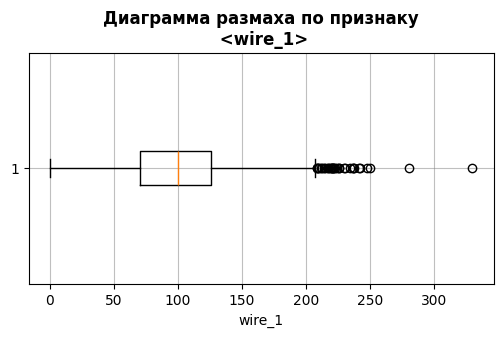

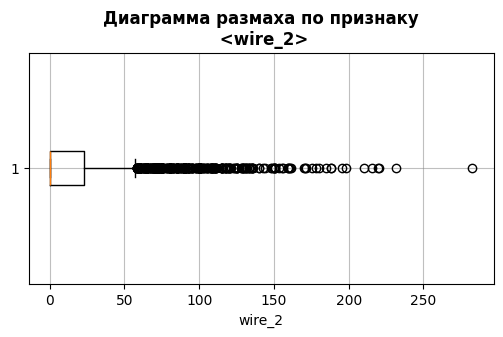

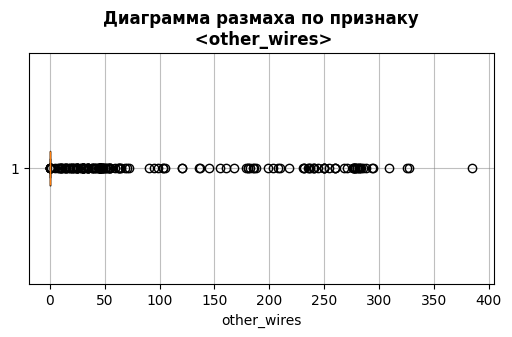

In [42]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(wire_df, wire_df.drop("key", axis=1).columns.tolist(), get_boxplot)

На диаграммах размаха наблюдается большое количество выбросов\
выше края статистически значимой выборки по всем признакам.

***

***ВЫВОД:***

По датафрейму **key_arc_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3214 значений.

   - По признаку `'active_power'`:
       - значения в диапазоне от 0,268 до 1,244.
       - среднее (0,661) и медиана (0,653) отличаются незначительно.

   - По признаку `'heat_time'`:
       - значения в диапазоне от 57 до 4189.
       - разница между средним (794,579) и медианой (770) небольшая.
       - хотя стандартное отклонение значительно (332,449).

   - По признаку `'mean_reactive_power'`:
       - значения в диапазоне от 0,098 до 0,961.
       - среднее (0,486) и медиана (0,482) отличаются незначительно.

2. В результате построения диаграмм размаха выявлено:
   - На диаграммах размаха видно большое количество выбросов по всем признакам.

По датафрейму **bulk_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3129 значений.

   - По всем признакам минимальные значения равны нулю.

   - По признакам `'bulk_12'`, `'bulk_14'`, `'bulk_15'`\
     среднее и медиана отличаются незначительно.

   - По остальным признакам медиана равна нулю.
2. В результате построения диаграмм размаха выявлено:
   - На диаграммах размаха по всем признакам, кроме `'bulk_15'`,\
     наблюдается большое количество выбросов выше края статистически значимой выборки.

По датафрейму **gas_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3239 значений.

   - Единственный признак `'gas_1'`
       - имеет значения в диапазоне от 0,008 до 77,995
       - среднее (11,002) и медиана (9,836) имеют ощутимое отличие в значениях.
2. В результате построения диаграмм размаха выявлено:
   - На диаграмме размаха наблюдается большое количество выбросов выше края статистически значимой выборки.

По датафрейму **interval_temp_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 2477 значений.

   - По признаку `'start_temp'`:
     - значения в диапазоне от 1191 до 1679.
     - среднее и медиана отличаются незначительно.

   - По признаку `'finish_temp'`:
     - значения в диапазоне от 1541 до 1700.
     - среднее и медиана отличаются незначительно.
2. 4 строки со неправдоподобным значением температуры расплавленной стали\
   (в признаке `'start_temp'`) были удалены.
3. В результате построения диаграмм размаха
   (после удаления 4-х строк) выявлено:
   - На диаграммах размаха по обоим признакам наблюдаются выбросы\
     как выше, так и ниже края статистически значимой выборки.
   - По признаку `'finish_temp'` выбросов значительно больше.

По датафрейму **wire_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3081 значение.

   - По признакам `'wire_2'`, `'other_wires'` минимальные значения равны нулю.

   - По признаку `'wire_1'` медиана (100,115) и среднее (100,004) отличаются незначительно.
2. В результате построения диаграмм размаха выявлено:
   - На диаграммах размаха наблюдается большое количество выбросов\
     выше края статистически значимой выборки по всем признакам.

<a id="3"></a>
# Объединение данных

Объединим данные в один датафрейм по номеру партии.\
При этом установим номер партии как индекс нового датафрейма.

In [43]:
# объединение датафреймов по ключу
gen_df = (
    pd.merge(key_arc_df, bulk_df, on=["key", "key"])
    .merge(gas_df, on=["key", "key"])
    .merge(interval_temp_df, on=["key", "key"])
    .merge(wire_df, on=["key", "key"])
).set_index("key")

In [44]:
# проверка объединения
gen_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2325 entries, 1 to 2499
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_active_power    2325 non-null   float64
 1   total_heat_time      2325 non-null   float64
 2   mean_reactive_power  2325 non-null   float64
 3   bulk_3               2325 non-null   float64
 4   bulk_4               2325 non-null   float64
 5   bulk_6               2325 non-null   float64
 6   bulk_12              2325 non-null   float64
 7   bulk_14              2325 non-null   float64
 8   bulk_15              2325 non-null   float64
 9   other_bulks          2325 non-null   float64
 10  gas_1                2325 non-null   float64
 11  start_temp           2325 non-null   float64
 12  finish_temp          2325 non-null   float64
 13  wire_1               2325 non-null   float64
 14  wire_2               2325 non-null   float64
 15  other_wires          2325 non-null   float6

***

***ВЫВОД:***

1. Были проведено объединение датафреймов:
   - **key_arc_df**
   - **gas_df**
   - **interval_temp_df**
   - **wire_df**\
   по номеру партии `'key'`.
2. Номер партии был установлен как индекс нового датафрейма **gen_df**

<a id="4"></a>
# Исследовательский анализ и предобработка датафрейма **gen_df**

## Статистический анализ датафрейма

Выведем описательную статистику для объединённого датафрейма.

In [45]:
# вывод описательной статистики для количественных признаков датасета
gen_df.describe().round(3)

,mean_active_power,total_heat_time,mean_reactive_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulks,gas_1,start_temp,finish_temp,wire_1,wire_2,other_wires
count,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000,2325.000
mean,0.664,807.988,0.489,47.297,37.332,22.469,208.508,153.972,120.027,20.361,11.379,1587.365,1593.366,102.412,17.606,5.164
std,0.128,340.888,0.098,75.228,58.670,55.831,157.138,81.398,84.674,69.069,6.396,23.623,11.210,43.535,33.643,32.877
min,0.268,57.000,0.196,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.008,1519.000,1541.000,0.000,0.000,0.000
25%,0.576,581.000,0.420,0.000,0.000,0.000,105.000,105.000,0.000,0.000,7.283,1571.000,1587.000,73.208,0.000,0.000
50%,0.656,778.000,0.485,0.000,0.000,0.000,206.000,149.000,107.000,0.000,10.101,1587.000,1593.000,101.088,0.000,0.000
75%,0.742,993.000,0.547,80.000,77.000,0.000,283.000,204.000,204.000,0.000,14.218,1603.000,1598.000,128.070,23.103,0.000
max,1.244,4189.000,0.961,454.000,281.000,503.000,1849.000,636.000,405.000,1187.000,77.995,1660.000,1653.000,330.314,282.780,385.009


В результате объединения датафреймов в количество строк уменьшилось: 2325 строк.

## Визуализация распределения признаков

Для наглядности визуализируем распределение признаков построением гистограммы распределения.

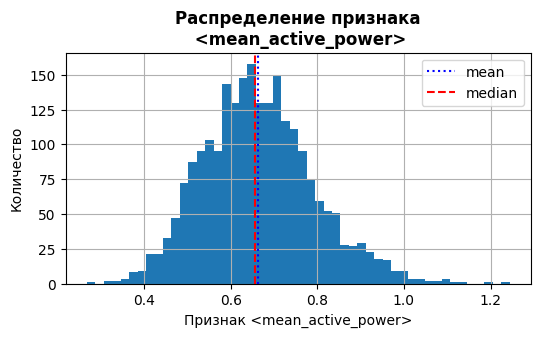

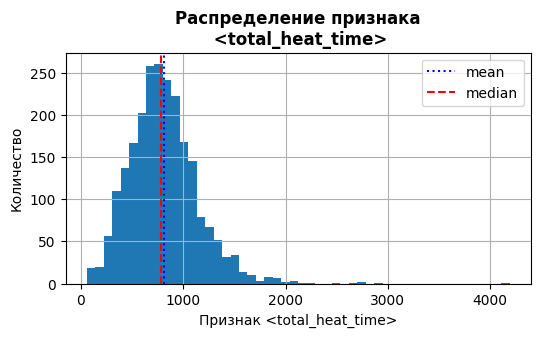

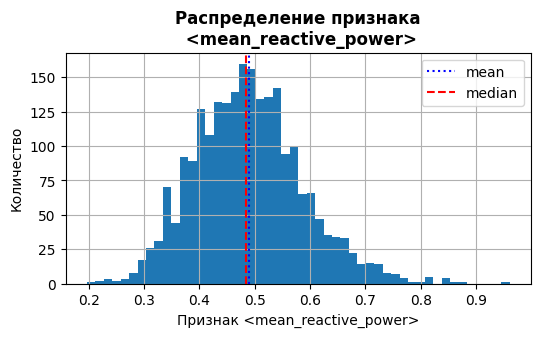

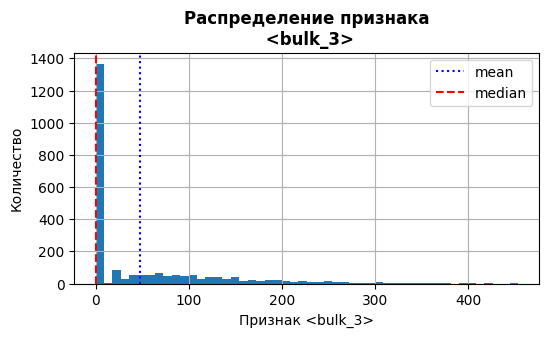

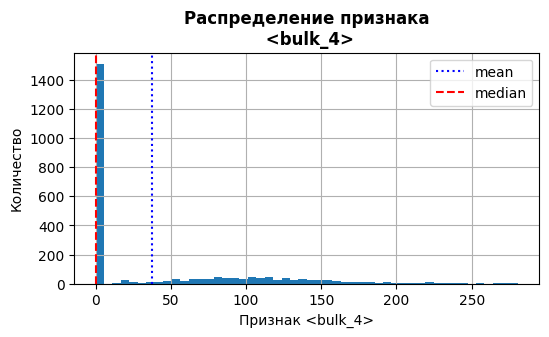

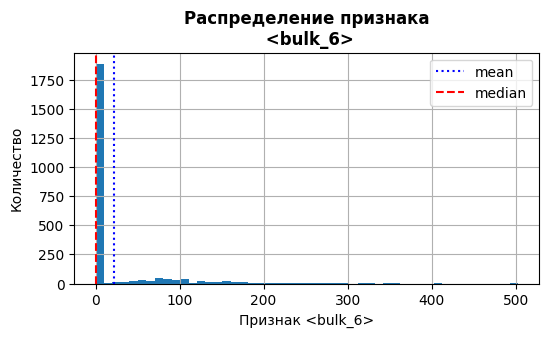

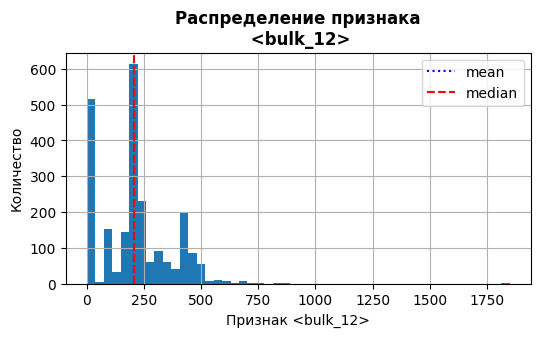

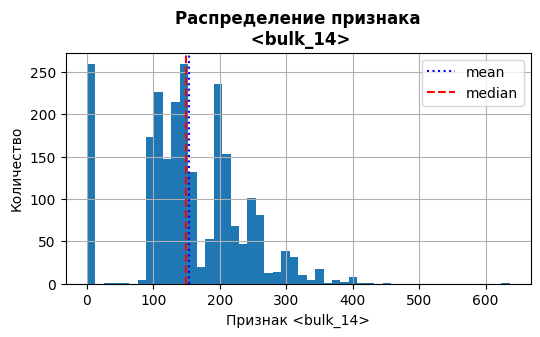

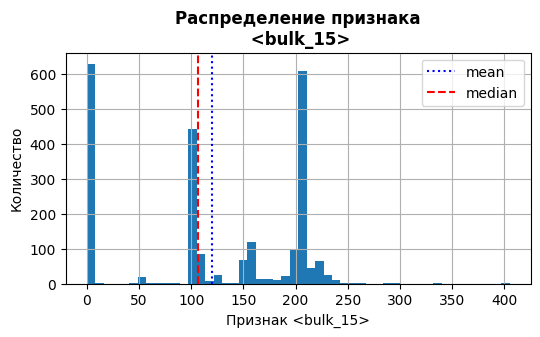

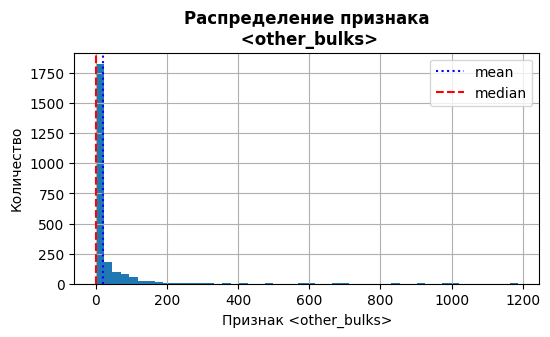

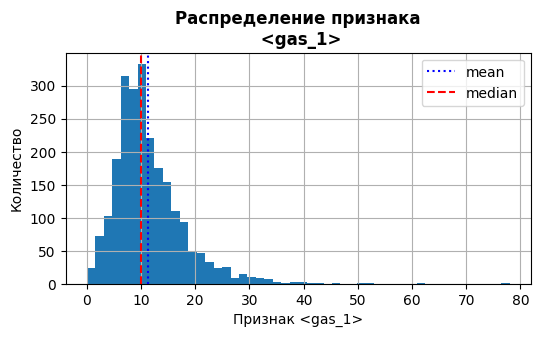

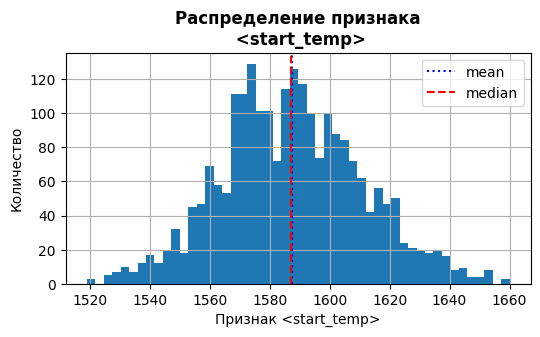

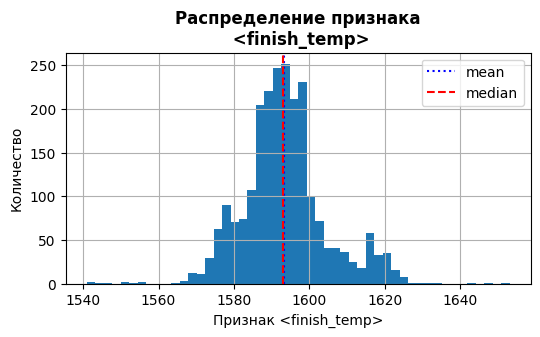

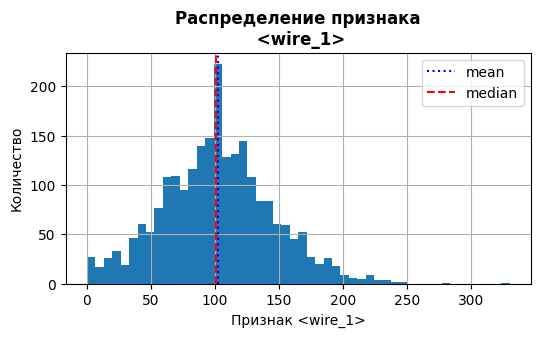

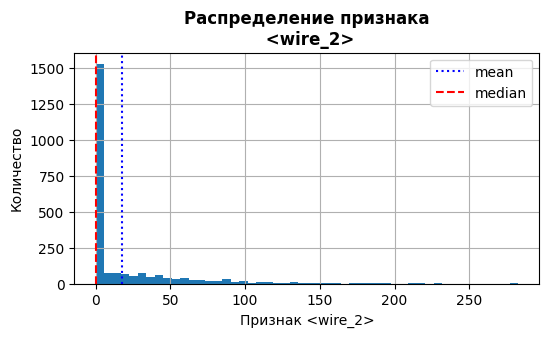

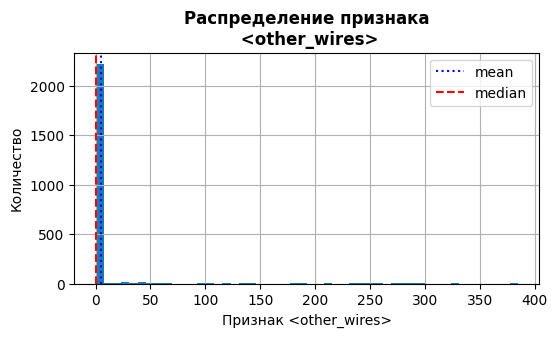

In [46]:
# функция для построения гистограммы
def get_hist(df, item):
    mean_value = df[item].mean()
    median_value = df[item].median()
    df[item].hist(bins=50)
    plt.title(f"Распределение признака\n <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество")
    plt.axvline(x=mean_value, label="mean", color="b", linestyle=":")
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    plt.legend()
    plt.show()


# построение гистограммы
set_plot(gen_df, gen_df.columns.tolist(), get_hist)

На гистограммах распределения:
- по признаку `'mean_active_power'` распределение мультимодальное, стремится к нормальному
- по признаку `'total_heat_time'` распределение смещённое с большим "хвостом" справа
- по признаку `'mean_reactive_power'` распределение мультимодальное, стремится к нормальному
- по признаку `'gas_1'` распределение смещённое с большим "хвостом" справа
- по признаку `'start_temp'` распределение мультимодальное, стремится к нормальному
- по признаку `'finish_temp'` распределение мультимодальное с "хвостами" справа и слева

## Корреляционный анализ датафрейма

Построим матрицу корреляции Пирсона

In [47]:
# построение матрицы корреляции с тепловой картой
gen_df.corr().round(3).style.background_gradient(cmap="coolwarm")

,mean_active_power,total_heat_time,mean_reactive_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulks,gas_1,start_temp,finish_temp,wire_1,wire_2,other_wires
mean_active_power,1.000000,0.049000,0.965000,0.027000,0.022000,-0.001000,0.038000,0.020000,0.040000,0.009000,0.040000,-0.007000,0.040000,0.036000,-0.014000,0.017000
total_heat_time,0.049000,1.000000,0.043000,0.092000,-0.029000,0.161000,0.466000,0.460000,0.295000,0.123000,0.396000,-0.384000,0.279000,0.056000,0.055000,0.049000
mean_reactive_power,0.965000,0.043000,1.000000,0.023000,0.023000,-0.002000,0.042000,0.016000,0.038000,0.004000,0.041000,-0.002000,0.033000,0.044000,-0.014000,0.017000
bulk_3,0.027000,0.092000,0.023000,1.000000,-0.295000,0.066000,0.018000,0.011000,-0.013000,-0.062000,0.060000,-0.113000,-0.037000,0.038000,0.095000,0.002000
bulk_4,0.022000,-0.029000,0.023000,-0.295000,1.000000,-0.252000,0.106000,-0.091000,0.101000,-0.016000,0.018000,0.166000,0.188000,0.298000,-0.268000,-0.036000
bulk_6,-0.001000,0.161000,-0.002000,0.066000,-0.252000,1.000000,-0.113000,0.177000,-0.110000,0.013000,0.139000,-0.127000,-0.182000,-0.236000,0.205000,-0.054000
bulk_12,0.038000,0.466000,0.042000,0.018000,0.106000,-0.113000,1.000000,0.481000,0.614000,0.000000,0.217000,-0.079000,0.267000,0.171000,-0.098000,-0.138000
bulk_14,0.020000,0.460000,0.016000,0.011000,-0.091000,0.177000,0.481000,1.000000,0.264000,-0.058000,0.268000,-0.180000,0.115000,-0.053000,0.037000,-0.032000
bulk_15,0.040000,0.295000,0.038000,-0.013000,0.101000,-0.110000,0.614000,0.264000,1.000000,-0.096000,0.043000,-0.062000,0.266000,0.119000,-0.096000,-0.139000
other_bulks,0.009000,0.123000,0.004000,-0.062000,-0.016000,0.013000,0.000000,-0.058000,-0.096000,1.000000,0.250000,0.094000,-0.116000,-0.121000,-0.022000,0.337000


Согласно шкале Чеддока между целевым признаком `'finish_temp'` и входными признаками выявлена линейная связь.\
Теснота связи по корреляции Пирсона:
- с входным признаком `'wire_1'` - умеренная
- с входным признаком `'start_temp'` - умеренная
- с входным признаком `'total_heat_time'` - слабая
- с входным признаком `'bulk_12'` - слабая
- с входным признаком `'bulk_15'` - слабая
- с входным признаком `'wire_2'` - слабая
- с входным признаком `'bulk_4'` - слабая
- с входным признаком `'bulk_6'` - слабая
- с входным признаком `'other_bulks'` - слабая
- с входным признаком `'bulk_14'` - слабая

Наблюдается мультиколлинеарность между входными признаками `'mean_active_power'` и `'mean_reactive_power'`.

Ослабим мультиколлинеарность, возведя признак `'mean_reactive_power'` в квадрат.

In [48]:
# добавление нового признака
gen_df["square_mean_reactive_power"] = gen_df["mean_reactive_power"] ** 2

Удалим признак `'mean_reactive_power'`

In [49]:
# удаление признака
gen_df = gen_df.drop("mean_reactive_power", axis=1)

Проверим преобразования

In [50]:
# вывод нескольких строк датафрейма
gen_df.head()

,mean_active_power,total_heat_time,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulks,gas_1,start_temp,finish_temp,wire_1,wire_2,other_wires,square_mean_reactive_power
key,,,,,,,,,,,,,,,,
1,0.607346,1098.0,0.0,43.0,0.0,206.0,150.0,154.0,0.0,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.183667
2,0.534852,811.0,0.0,73.0,0.0,206.0,149.0,154.0,0.0,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.132015
3,0.812728,655.0,0.0,34.0,0.0,205.0,152.0,153.0,0.0,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.345146
4,0.676622,741.0,0.0,81.0,0.0,207.0,153.0,154.0,0.0,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.264451
5,0.563238,869.0,0.0,78.0,0.0,203.0,151.0,152.0,0.0,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.178082


***

***ВЫВОД:***

1. В результате объединения датафреймов в количество строк уменьшилось: 2325 строк.
2. Для визуализации распределения признаков были построены гистограммы распределения.
3. На гистограммах распределения:
   - по признаку `'mean_active_power'` распределение мультимодальное, стремится к нормальному
   - по признаку `'total_heat_time'` распределение смещённое с большим "хвостом" справа
   - по признаку `'mean_reactive_power'` распределение мультимодальное, стремится к нормальному
   - по признаку `'gas_1'` распределение смещённое с большим "хвостом" справа
   - по признаку `'start_temp'` распределение мультимодальное, стремится к нормальному
   - по признаку `'finish_temp'` распределение мультимодальное с "хвостами" справа и слева
4. Был проведён корреляционный анализ построением матрицы корреляции Пирсона
5. Согласно шкале Чеддока между целевым признаком `'finish_temp'` и входными признаками выявлена линейная связь.\
   Теснота связи по корреляции Пирсона:
    - с входным признаком `'wire_1'` - умеренная
    - с входным признаком `'start_temp'` - умеренная
    - с входным признаком `'total_heat_time'` - слабая
    - с входным признаком `'bulk_12'` - слабая
    - с входным признаком `'bulk_15'` - слабая
    - с входным признаком `'wire_2'` - слабая
    - с входным признаком `'bulk_4'` - слабая
    - с входным признаком `'bulk_6'` - слабая
    - с входным признаком `'other_bulks'` - слабая
    - с входным признаком `'bulk_14'` - слабая
6. Наблюдается мультиколлинеарность между входными признаками `'mean_active_power'` и `'mean_reactive_power'`.
7. Мультиколлинеарность была ослаблена возведением признака `'mean_reactive_power'` в квадрат.
8. Признак `'mean_reactive_power'` был удалён.

<a id="5"></a>
# Подготовка данных

Перед подготовкой удалим лишние переменные

In [51]:
del arc_df
del arc_file
del bulk_df
del bulk_file
del bulk_time_df
del bulk_time_file
del by_max_time
del by_min_time
del col
del col_drop_lst
del df
del df_lst
del df_lst_remove
del finish_temp
del gas_df
del gas_file
del get_hist
del get_info
del get_method
del get_percent_passes
del get_read_file
del interval_temp_df
del key_arc_df
del lst_columns
del rename_columns
del start_temp
del temp_df
del temp_file
del wire_df
del wire_file
del wire_time_df
del wire_time_file

Так как тагрет - количественный признак, будем решать задачу регрессии.

Для построения модели используем пайплайны.

Для масштабирования количественных признаков будем использовать скейлеры:
 - MinMaxScaler()
 - StandardScaler()
 - RobustScaler()
 - и аргумент "passthrough" - вариант без масштабирования.

Выделим таргет и входящие признаки.

In [52]:
# разделение датафрейма на целевой и входные признаки
X = gen_df.drop(columns="finish_temp")
y = gen_df["finish_temp"]

Сформируем тренировочные и тестовые данные.

In [53]:
# формирование тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

Проверим разделение

In [54]:
print(f"Размер обучающей {X_train.shape} и тестовой {X_test.shape} выборок.")
print(f"Размер таргета обучающей {y_train.shape} и тестовой {y_test.shape} выборок.")

Размер обучающей (1743, 15) и тестовой (582, 15) выборок.
Размер таргета обучающей (1743,) и тестовой (582,) выборок.


Создадим список количественных признаков датафрейма

In [55]:
# создание списка с признаками
num_columns = X.columns.to_list()

In [56]:
# создание общего pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ("num", MinMaxScaler(), num_columns),
    ],
    remainder="passthrough",
)

Визуализируем выбросы на тренировочной выборке, построив диаграммы размаха.

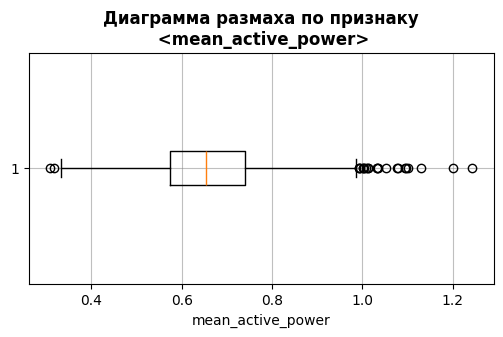

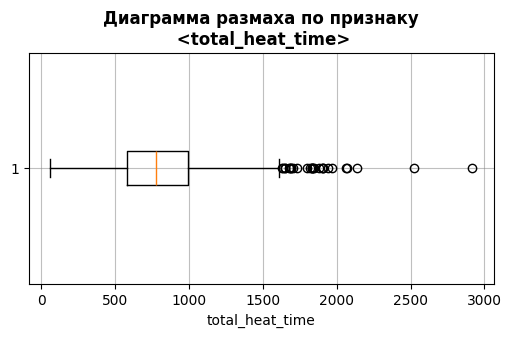

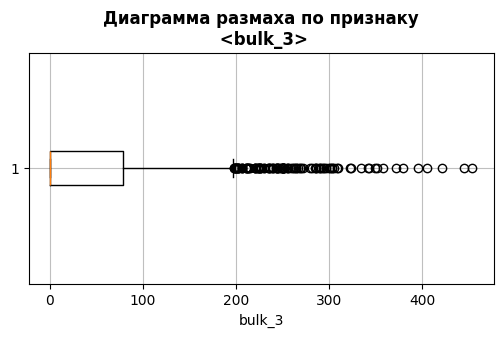

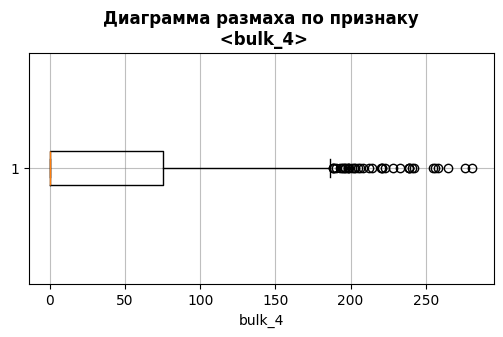

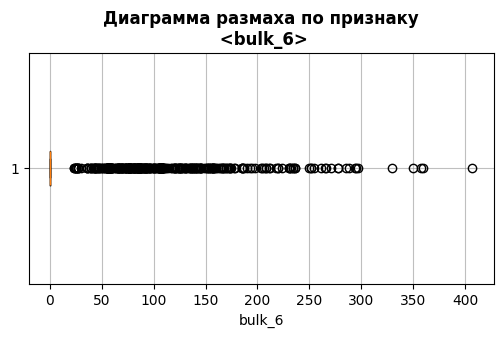

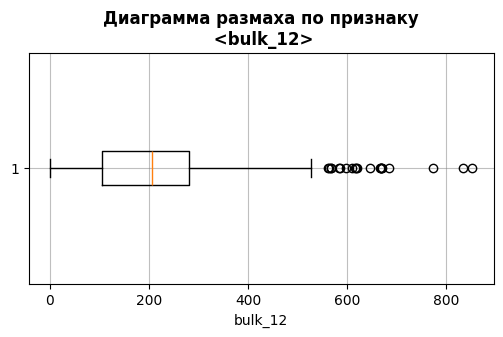

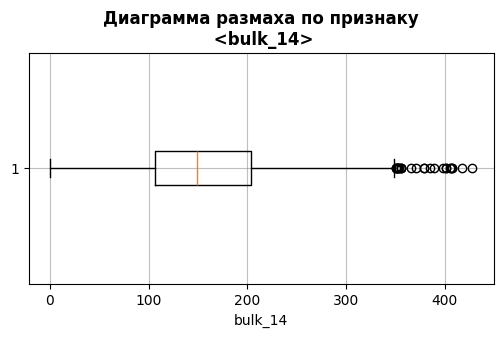

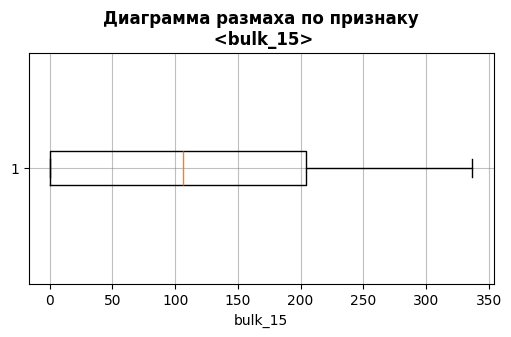

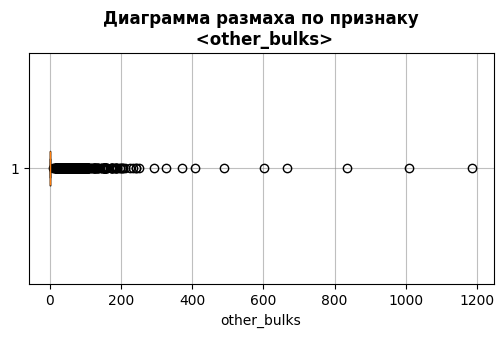

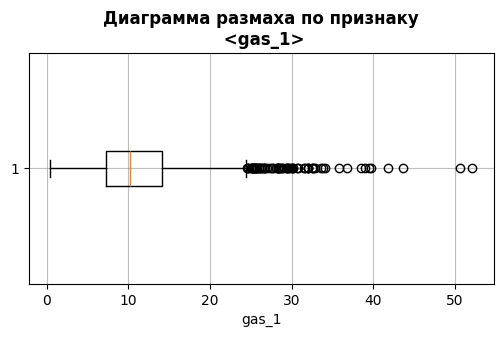

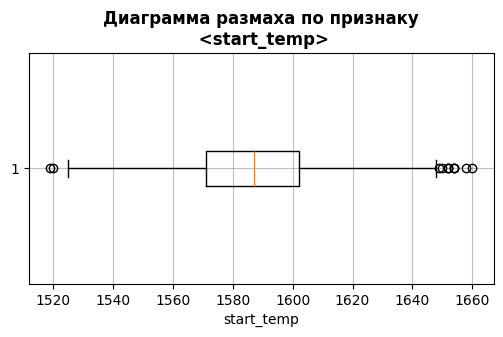

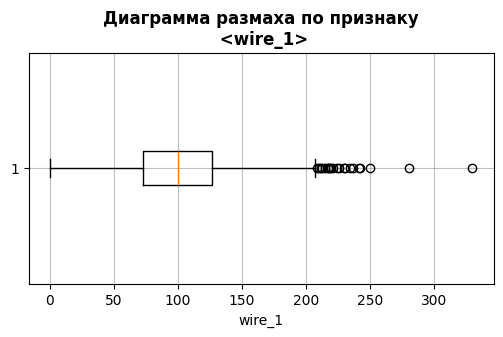

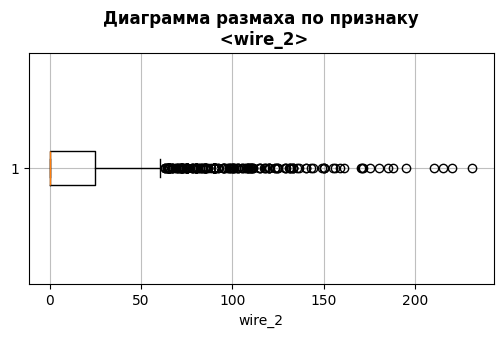

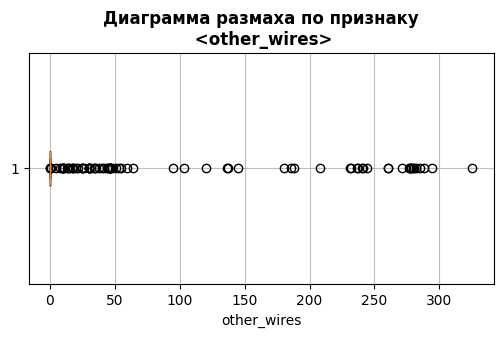

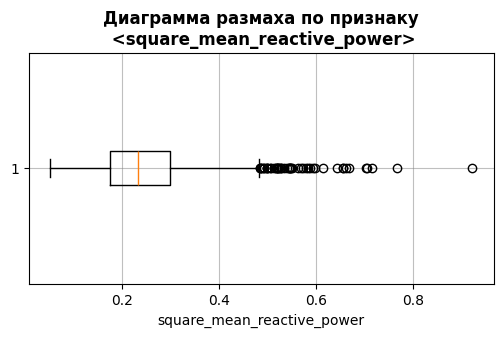

In [57]:
# построение диаграмм размаха
set_plot(X_train, num_columns, get_boxplot)

На диаграммах размаха наблюдается большое количество выбросов выше и ниже края\
статистически значимой выборки по признаку `'mean_active_power'`.\
Также присутствует большое количество выбросов значительно выше\
края статистически значимой выборки по признаку `'total_heat_time'`.

Удалим значения выше 99-го перцентиля и ниже 1-го перцентиля по признаку `'mean_active_power'`\
и значения выше 99-го перцентиля по признаку `'total_heat_time'`,\
чтобы ограничить выбросы.

In [58]:
# объявление нижней и верхней границ выборки
mean_active_power_low = X_train["mean_active_power"].quantile(0.01)
mean_active_power_up = X_train["mean_active_power"].quantile(0.99)
total_heat_time_up = X_train["total_heat_time"].quantile(0.99)

# перезапись датафрейма со срезом данных между объявленных границ
X_train = X_train.query(
    "mean_active_power >= @mean_active_power_low and mean_active_power <= @mean_active_power_up and total_heat_time <= @total_heat_time_up"
)

Также удалим соответствующие значения таргета.

In [59]:
# объявление списка индексов тренировочной выборки
ind_lst = X_train.index
# перезапись объекта Series с таргетом
y_train = y_train[y_train.index.isin([*ind_lst])]

Преобразуем таргеты тестовой и тренировочной части в массивы.

In [60]:
# преобразование в массивы numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

***

***ВЫВОД:***

1. Перед подготовкой были удалены лишние переменные
2. Для подготовки данных были выбраны скейлеры.
3. Датафрейм был разделён на выборки: тренировочную и тестовую.
4. Были визуализированы выбросы на тренировочной выборке построением диаграмм размаха.
5. На диаграммах размаха наблюдается большое количество выбросов выше и ниже края\
   статистически значимой выборки по признаку `'mean_active_power'`.\
   Также присутствует большое количество выбросов значительно выше\
   края статистически значимой выборки по признаку `'total_heat_time'`.
6. Были удалены значения выше 99-го перцентиля и ниже 1-го перцентиля по признаку `'mean_active_power'`\
   и значения выше 99-го перцентиля по признаку `'total_heat_time'`,\
   чтобы ограничить выбросы.
7. Также были удалены соответствующие значения таргета тренировочной выборки.
8. Был создан пайплайн для подготовки данных.

<a id="6"></a>
# Обучение моделей

Будем обучать модели с гиперпараметрами:
 - RandomForestRegressor() с ***max_depth***, ***n_estimators***
 - LGBMRegressor() с ***max_depth***, ***num_leaves***
 - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***

Для подбора лучшей модели с гиперпараметрами будем использовать
 - GridSearchCV()

Для оценки качества работы модели применим метрику MAE

Создадим итоговый пайплайн

In [61]:
# создание итогового pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", RandomForestRegressor(random_state=RANDOM_STATE)),
    ]
)

Опишем модели с гиперпараметрами

In [62]:
param_grid = [
    # словарь для модели RandomForestRegressor()
    {
        "models": [RandomForestRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 20, 2),
        "models__n_estimators": range(3, 20, 2),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели LGBMRegressor()
    {
        "models": [LGBMRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(3, 10, 3),
        "models__num_leaves": range(2, 10),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели GradientBoostingRegressor()
    {
        "models": [GradientBoostingRegressor()],
        "models__max_depth": range(3, 7, 3),
        "models__min_samples_split": range(4, 11, 2),
        "models__n_estimators": range(11, 20, 2),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
]

In [63]:
# подбор лучшей модели с гиперпараметрами
model = GridSearchCV(
    pipe_final,
    param_grid,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)
model.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", model.best_estimator_)
print(f"Качество модели по метрике MAE - {round(model.best_score_, 3)*-1}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 1689, number of used features: 15
[LightGBM] [Info] Start training from score 1593.044405
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['mean_active_power',
                                                   'total_heat_time', 'bulk_3',
                                                   'bulk_4', 'bulk_6',
                                                   'bulk_12', 'bulk_14',
                                                   'bulk_15', 'other_bulks',
                                                   'gas_1', 'start_temp',
         

***

***ВЫВОД:***

1. При подборе лучшей модели был использован общий пайплайн для всех моделей\
    и инструмент подбора гиперпараметров **GridSearchCV()**
2. Были обучены модели с гиперпараметрами:
   - RandomForestRegressor() с *max_depth*, *n_estimators*
   - LGBMRegressor() с *max_depth*, *num_leaves*
   - GradientBoostingRegressor() с *max_depth*, *min_samples_split*
4. Для оценки качества модели была использована метрика MAE
5. Лучшая модель - LGBMRegressor() с гиперпараметрами *max_depth*=9 и *num_leaves*=8
6. Качество модели на кросс-валидации по метрике MAE - 6.01

<a id="7"></a>
# Проверка и анализ лучшей модели

## Проверка лучшей модели на адекватность

Проверим модель на адекватность с помощью DummyRegressor()

Обучим Dummy-модель и получим предсказания.

In [64]:
param_grid_dummy = [
    # словарь для модели DummyRegressor()
    {
        "models": [DummyRegressor()],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
]

In [65]:
dummy_model = GridSearchCV(
    pipe_final,
    param_grid_dummy,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)
dummy_model.fit(X_train, y_train)

print("Dummy-модель и её параметры:\n\n", dummy_model.best_estimator_)
print(f"Качество модели по метрике MAE - {round(dummy_model.best_score_, 3)*-1}")

Dummy-модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['mean_active_power',
                                                   'total_heat_time', 'bulk_3',
                                                   'bulk_4', 'bulk_6',
                                                   'bulk_12', 'bulk_14',
                                                   'bulk_15', 'other_bulks',
                                                   'gas_1', 'start_temp',
                                                   'wire_1', 'wire_2',
                                                   'other_wires',
                                                   'square_mean_reactive_power'])])),
                ('models', DummyRegressor())])
Качество модели по метрике MAE - 7.932


Качество dummy-модели на кросс-валидации по метрике MAE - 7,932\
Лучшая модель LGBMRegressor() прошла проверку на адекватность.

## Проверка лучшей модели на тестовой выборке

Проверим качество лучшей модели на тестовой выборке.

In [66]:
# получение предсказаний на тестовой выборке
pred = model.best_estimator_.predict(X_test)
# получение предсказаний модели
print(
    f"Качество модели по метрике MAE на тестовой выборке - {round(mean_absolute_error(y_test, pred), 3)}"
)

Качество модели по метрике MAE на тестовой выборке - 6.793


## Анализ важности признаков лучшей модели

Оценим общую значимость каждого входного признака в прогноз модели.\
Оценим признаки методом SHAP.\
Для этого воспользуемся обученной лучшей моделью.

In [67]:
# переформирование предсказания лучшей модели в DataFrame
pred_df = lambda x: model.best_estimator_.predict(
    pd.DataFrame(x, columns=X_train.columns)
)

In [68]:
# создаем объект explainer для модели
explainer = shap.KernelExplainer(pred_df, X_test)
shap_values = explainer.shap_values(X_test, nsamples=50)

  0%|          | 0/582 [00:00<?, ?it/s]

Построим график важности признаков

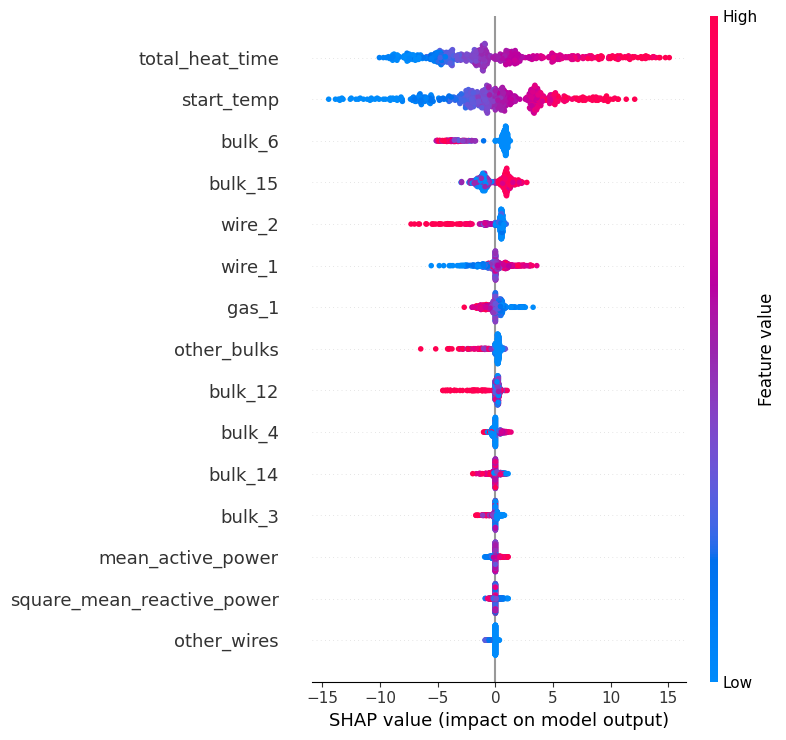

In [69]:
# график важности признаков
shap.summary_plot(shap_values, X_test)

Самые важные признаки для модели:
- `'total_heat_time'`
- `'start_temp'`

Чем выше первоначальная температура сплава,\
и (или) чем больше общее время нагрева,\
тем выше таргет - финальная температура сплава.

Мало значимые признаки:
- `'bulk_4'`
- `'bulk_3'`
- `'mean_active_power'`
- `'square_mean_reactive_power'`
- `'other_wires'`

Остальные признаки оказывают среднее разнонаправленное влияние на прогнозы модели.

Наблюдения за изменениями значений важных признаков можно использовать\
для прогноза финальной температуры сплава,\
далее - для уменьшения потребления электроэнергии на этапе обработки стали,\
и как следствие - для оптимизации производственных расходов.

***

***ВЫВОД:***

1. Была проведена проверка лучшей модели LGBMRegressor() на адекватность.
2. Качество dummy-модели на кросс-валидации по метрике MAE - 7,932, что существенно выше, чем у лучшей модели LGBMRegressor()
3. Качество лучшей модели LGBMRegressor() по метрике MAE на тестовой выборке - 6.793
4. Проведённый анализ признаков лучшей модели показал:
   - Самые важные признаки для модели:
      - `'total_heat_time'`
      - `'start_temp'`

   - Чем выше первоначальная температура сплава,\
     и (или) чем больше общее время нагрева,\
     тем выше таргет - финальная температура сплава.

   - Мало значимые признаки:
      - `'bulk_4'`
      - `'bulk_3'`
      - `'mean_active_power'`
      - `'square_mean_reactive_power'`
      - `'other_wires'`

   - Остальные признаки оказывают среднее разнонаправленное влияние на прогнозы модели.

<a id="8"></a>
# Общий вывод и рекомендации заказчику

**ВХОДНЫЕ ДАННЫЕ:**

1. Исследование проведено на базе данных металлургического комбината «Стальная птица».
2. Данные, предоставленные комбинатом, состоят из нескольких файлов, полученных из разных источников:
   - *data_arc_new.csv* — данные об электродах;
   - *data_bulk_new.csv* — данные о подаче сыпучих материалов (объём);
   - *data_bulk_time_new.csv* — данные о подаче сыпучих материалов (время);
   - *data_gas_new.csv* — данные о продувке сплава газом;
   - *data_temp_new.csv* — результаты измерения температуры;
   - *data_wire_new.csv* — данные о проволочных материалах (объём);
   - *data_wire_time_new.csv* — данные о проволочных материалах (время).
3. Данные загружены в датафреймы.
4. Наименования столбцов во всех датафреймах были приведены к единому виду.

**НА ЭТАПЕ ПРЕДОБРАБОТКИ ДАННЫХ:**
1. В результате проверки на пропущенные значения в датафреймах были выявлены пропуски:
   - **arc_df** - 0
   - **bulk_df** - 35776
   - **bulk_time_df** - 35776
   - **gas_df** - 0
   - **temp_df** - 3427
   - **wire_df** - 23385
   - **wire_time_df** - 23385
2. В датафреймах
   - **bulk_df**
   - **bulk_time_df**
   - **wire_df**
   - **wire_time_df**\
   доля пропусков в признаках достигает почти 100%.
3. Так как признаки с большим количеством пропусков не информативны для обучения модели и создают шум,\
   были удалены столбцы, в которых заполнено менее 10% значений.
4. Перед удалением данные в признаках, которые подлежали удалению,\
   были просуммированны с записью суммы в новый признак:
   - в **bulk_df** в признак `'other_bulks'`
   - в **wire_df** в признак `'other_wires'`
5. Пропуски в значениях `'bulk_'` и `'wire_'` в датафреймах:
   - **bulk_df**,
   - **wire_df**\
   означают отсутствие данных.\
   Поэтому они были заполнены нулевыми значениями.
6. Данные датафрейма **temp_df** были сгруппированы так,\
   чтобы найти начальную и конечную температуру каждой партии.
7. Так как партии с отсутствующей информацией о начальной,\
   либо о конечной температуре не информативны для предсказания,\
   были удалены строки с отсутствующими значениями из **temp_df**.
8. В датафрейме **arc_df** была найдена одна строка с аномальным (отрицательным) значением в признаке `'reactive_power'`\
   Эта строка была удалена.
9. Для конечной температуры сплава очевидно может быть важен такой параметр, как время нагрева дугой.\
   Поэтому было найдено время нагрева сначала для каждого цикла нагрева в датафрейме **arc_df**.\
   Найденное время было переведено в секунды.
10. Данные датафрейма **arc_df** были перегруппированны с агрегацией значений:
   - для признака `'heat_time'` найдено общее время нагрева за партию
   - для признака `'active_power'` найдена средняя мощность за партию
   - для признака `'reactive_power'` найдена средняя мощность за партию\
     Данные записаны в новый датафрейм.
11. Датафреймы с временем подачи материалов **bulk_time_df**, **wire_time_df**\
    для обучения модели использованы не будут.

**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ:**

По датафреймам было выявлено:

По датафрейму **key_arc_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3214 значений.

   - По признаку `'active_power'`:
       - значения в диапазоне от 0,268 до 1,244.
       - среднее (0,661) и медиана (0,653) отличаются незначительно.

   - По признаку `'heat_time'`:
       - значения в диапазоне от 57 до 4189.
       - разница между средним (794,579) и медианой (770) небольшая.
       - хотя стандартное отклонение значительно (332,449).

   - По признаку `'reactive_power'`:
       - значения в диапазоне от 0,098 до 0,961.
       - среднее (0,486) и медиана (0,482) отличаются незначительно.
2. Единственная строка с отрицательным значением реактивной мощности была удалена.
3. В результате построения диаграмм размаха (после удаления строки\
   с отрицательным значением реактивной мощности) выявлено:
   - На диаграммах размаха видно большое количество выбросов по всем признакам.

По датафрейму **bulk_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3129 значений.

   - По всем признакам минимальные значения равны нулю.

   - По признакам `'bulk_12'`, `'bulk_14'`, `'bulk_15'`\
     среднее и медиана отличаются незначительно.

   - По остальным признакам медиана равна нулю.
2. В результате построения диаграмм размаха выявлено:
   - На диаграммах размаха по всем признакам, кроме `'bulk_15'`,\
     наблюдается большое количество выбросов выше края статистически значимой выборки.

По датафрейму **gas_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3239 значений.

   - Единственный признак `'gas_1'`
       - имеет значения в диапазоне от 0,008 до 77,995
       - среднее (11,002) и медиана (9,836) имеют ощутимое отличие в значениях.
2. В результате построения диаграмм размаха выявлено:
   - На диаграмме размаха наблюдается большое количество выбросов выше края статистически значимой выборки.

По датафрейму **interval_temp_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 2477 значений.

   - По признаку `'start_temp'`:
     - значения в диапазоне от 1191 до 1679.
     - среднее и медиана отличаются незначительно.

   - По признаку `'finish_temp'`:
     - значения в диапазоне от 1541 до 1700.
     - среднее и медиана отличаются незначительно.
2. 4 строки со неправдоподобным значением температуры расплавленной стали\
   (в признаке `'start_temp'`) были удалены.
3. В результате построения диаграмм размаха
   (после удаления 4-х строк) выявлено:
   - На диаграммах размаха по обоим признакам наблюдаются выбросы\
     как выше, так и ниже края статистически значимой выборки.
   - По признаку `'finish_temp'` выбросов значительно больше.

По датафрейму **wire_df**:
1. В результате вывода описательной статистики выявлено:
   - В датафрейме 3081 значение.

   - По признакам `'wire_2'`, `'other_wires'` минимальные значения равны нулю.

   - По признаку `'wire_1'` медиана (100,115) и среднее (100,004) отличаются незначительно.
2. В результате построения диаграмм размаха выявлено:
   - На диаграммах размаха наблюдается большое количество выбросов\
     выше края статистически значимой выборки по всем признакам.

**НА ЭТАПЕ ОБЪЕДИНЕНИЯ ДАННЫХ:**

1. Были проведено объединение датафреймов:
   - **key_arc_df**
   - **gas_df**
   - **interval_temp_df**
   - **wire_df**\
   по номеру партии `'key'`.
2. Номер партии был установлен как индекс нового датафрейма **gen_df**

**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА И ПРЕДОБРАБОТКИ ДАТАФРЕЙМА **gen_df**:**

1. В результате объединения датафреймов в количество строк уменьшилось: 2325 строк.
2. Для визуализации распределения признаков были построены гистограммы распределения.
3. На гистограммах распределения:
   - по признаку `'mean_active_power'` распределение мультимодальное, стремится к нормальному
   - по признаку `'total_heat_time'` распределение смещённое с большим "хвостом" справа
   - по признаку `'mean_reactive_power'` распределение мультимодальное, стремится к нормальному
   - по признаку `'gas_1'` распределение смещённое с большим "хвостом" справа
   - по признаку `'start_temp'` распределение мультимодальное, стремится к нормальному
   - по признаку `'finish_temp'` распределение мультимодальное с "хвостами" справа и слева
4. Был проведён корреляционный анализ построением матрицы корреляции Пирсона
5. Согласно шкале Чеддока между целевым признаком `'finish_temp'` и входными признаками выявлена линейная связь.\
   Теснота связи по корреляции Пирсона:
    - с входным признаком `'wire_1'` - умеренная
    - с входным признаком `'start_temp'` - умеренная
    - с входным признаком `'total_heat_time'` - слабая
    - с входным признаком `'bulk_12'` - слабая
    - с входным признаком `'bulk_15'` - слабая
    - с входным признаком `'wire_2'` - слабая
    - с входным признаком `'bulk_4'` - слабая
    - с входным признаком `'bulk_6'` - слабая
    - с входным признаком `'other_bulks'` - слабая
    - с входным признаком `'bulk_14'` - слабая
6. Наблюдается мультиколлинеарность между входными признаками `'mean_active_power'` и `'mean_reactive_power'`.
7. Мультиколлинеарность была ослаблена возведением признака `'mean_reactive_power'` в квадрат.
8. Признак `'mean_reactive_power'` был удалён.

**НА ЭТАПЕ ПОДГОТОВКИ ДАННЫХ:**

1. Перед подготовкой были удалены лишние переменные
2. Для подготовки данных были выбраны скейлеры.
3. Датафрейм был разделён на выборки: тренировочную и тестовую.
4. Были визуализированы выбросы на тренировочной выборке построением диаграмм размаха.
5. На диаграммах размаха наблюдается большое количество выбросов выше и ниже края\
   статистически значимой выборки по признаку `'mean_active_power'`.\
   Также присутствует большое количество выбросов значительно выше\
   края статистически значимой выборки по признаку `'total_heat_time'`.
6. Были удалены значения выше 99-го перцентиля и ниже 1-го перцентиля по признаку `'mean_active_power'`\
   и значения выше 99-го перцентиля по признаку `'total_heat_time'`,\
   чтобы ограничить выбросы.
7. Также были удалены соответствующие значения таргета тренировочной выборки.
8. Был создан пайплайн для подготовки данных.

**НА ЭТАПЕ ОБУЧЕНИЯ МОДЕЛЕЙ:**

1. При подборе лучшей модели был использован общий пайплайн для всех моделей\
    и инструмент подбора гиперпараметров **GridSearchCV()**
2. Были обучены модели с гиперпараметрами:
   - RandomForestRegressor() с *max_depth*, *n_estimators*
   - LGBMRegressor() с *max_depth*, *num_leaves*
   - GradientBoostingRegressor() с *max_depth*, *min_samples_split*
4. Для оценки качества модели была использована метрика MAE
5. Лучшая модель - LGBMRegressor() с гиперпараметрами *max_depth*=3 и *num_leaves*=8
6. Качество модели на кросс-валидации по метрике MAE - 6.01

**НА ЭТАПЕ ПРОВЕРКИ ЛУЧШЕЙ МОДЕЛИ:**

1. Была проведена проверка лучшей модели LGBMRegressor() на адекватность.
2. Качество dummy-модели на кросс-валидации по метрике MAE - 7,932, что существенно выше, чем у лучшей модели LGBMRegressor()
3. Качество лучшей модели LGBMRegressor() по метрике MAE на тестовой выборке - 6.793
4. Проведённый анализ признаков лучшей модели показал:
   - Самые важные признаки для модели:
      - `'total_heat_time'`
      - `'start_temp'`

   - Чем выше первоначальная температура сплава,\
     и (или) чем больше общее время нагрева,\
     тем выше таргет - финальная температура сплава.

   - Мало значимые признаки:
      - `'bulk_4'`
      - `'bulk_3'`
      - `'mean_active_power'`
      - `'square_mean_reactive_power'`
      - `'other_wires'`

   - Остальные признаки оказывают среднее разнонаправленное влияние на прогнозы модели.

**РЕКОМЕНДАЦИИ ЗАКАЗЧИКУ:**

Наблюдения за изменениями значений важных признаков можно использовать\
для прогноза финальной температуры сплава,\
далее - для уменьшения потребления электроэнергии на этапе обработки стали,\
и как следствие - для оптимизации производственных расходов.